In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[1.6791e-01, 8.1629e-01, 3.4709e-06, 1.2757e-02, 1.5951e-07, 1.3868e-07,
          1.2209e-08, 2.1628e-05, 2.9354e-13, 3.0133e-03]]),
 tensor([[0.2588, 0.3551, 0.0299, 0.1546, 0.0162, 0.0157, 0.0097, 0.0431, 0.0012,
          0.1158]]),
 tensor([[0.1954, 0.2289, 0.0664, 0.1510, 0.0488, 0.0482, 0.0378, 0.0798, 0.0130,
          0.1307]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

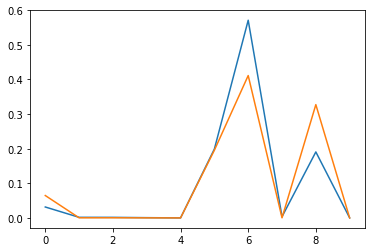

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

In [14]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, aug_alpha:bool=False):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): self.alpha[0] = self.true_mu
                
    def on_batch_begin(self) -> None:
        if self.aug_alpha:
            self.rand = torch.randn_like(self.alpha, device=self.wrapper.device)/10
            with torch.no_grad(): self.alpha += self.rand
        self.wrapper.x = self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        if self.aug_alpha:
             with torch.no_grad(): self.alpha -= self.rand
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor: pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:  
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
#         print(h,ikk)
        return ikk
        
    def on_forwards_end(self) -> None:
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

In [15]:
class PaperInferno(AbsInferno):
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, aug_alpha:bool=False):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, aug_alpha=aug_alpha)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def on_train_begin(self) -> None:
        super().on_train_begin()
#         if self.float_l:
#             with torch.no_grad(): self.alpha[-1] = 1
        
    def aug_data(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        i = 1
        if self.float_r:
            x[:,0] += self.alpha[i]
            i += 1
        if self.float_l:
            x[:,2] *= (self.alpha[i]+self.l_init)/self.l_init
        return x

In [16]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [17]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=0, float_l=1, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie1l.h5'),EarlyStopping(10)])

1: Train=451.3694140625 Valid=392.1666638183594
2: Train=373.17552307128904 Valid=372.1685968017578
3: Train=357.0025622558594 Valid=352.846005859375
4: Train=339.1401715087891 Valid=340.53924682617185
5: Train=329.8262094116211 Valid=333.11225952148436
6: Train=324.2759596252441 Valid=328.57863037109377
7: Train=319.99149200439456 Valid=324.00316955566404
8: Train=315.90166931152345 Valid=320.7999963378906
9: Train=312.80955627441404 Valid=317.22758056640623
10: Train=309.9976136779785 Valid=313.91990478515623
11: Train=305.9430258178711 Valid=310.61080261230467
12: Train=304.13693969726563 Valid=307.4541845703125
13: Train=301.48649139404296 Valid=304.9738720703125
14: Train=299.3406599426269 Valid=302.49622131347655
15: Train=295.9239039611816 Valid=299.7528771972656
16: Train=294.11014251708986 Valid=297.7457086181641
17: Train=291.6915953063965 Valid=295.6281768798828
18: Train=289.62848709106447 Valid=293.25486145019534
19: Train=287.7996653747559 Valid=291.95443237304687
20: Tra

155: Train=245.0415299987793 Valid=251.6192153930664
156: Train=245.27083435058594 Valid=251.7389422607422
157: Train=245.2630857849121 Valid=251.29357879638673
158: Train=244.9049905395508 Valid=251.8083367919922
159: Train=245.17544174194336 Valid=251.4647067260742
160: Train=245.482216796875 Valid=251.30804718017578
161: Train=244.9777816772461 Valid=251.09767486572267
162: Train=244.89156448364258 Valid=251.3540805053711
163: Train=244.98877655029298 Valid=251.28892181396483
164: Train=244.89972930908203 Valid=250.8483935546875
165: Train=245.28588409423827 Valid=251.42130432128906
166: Train=245.08479888916017 Valid=250.73138580322265
167: Train=245.45488357543945 Valid=251.28012084960938
168: Train=245.01422561645506 Valid=250.9683395385742
169: Train=244.77432235717774 Valid=250.63817657470702
170: Train=244.53422058105468 Valid=250.85886138916015
171: Train=244.61453079223634 Valid=250.7427243041992
172: Train=244.5985140991211 Valid=250.99004272460937
173: Train=244.0479673767

In [18]:
model.save('weights/Inferno_Test_exact_bm1l.h5')

In [17]:
model.load('weights/Inferno_Test_exact_bm1l.h5')

# Results

In [18]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [19]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [20]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,5,1.0
1,5,1.0
2,5,1.0
3,5,1.0
4,2,1.0


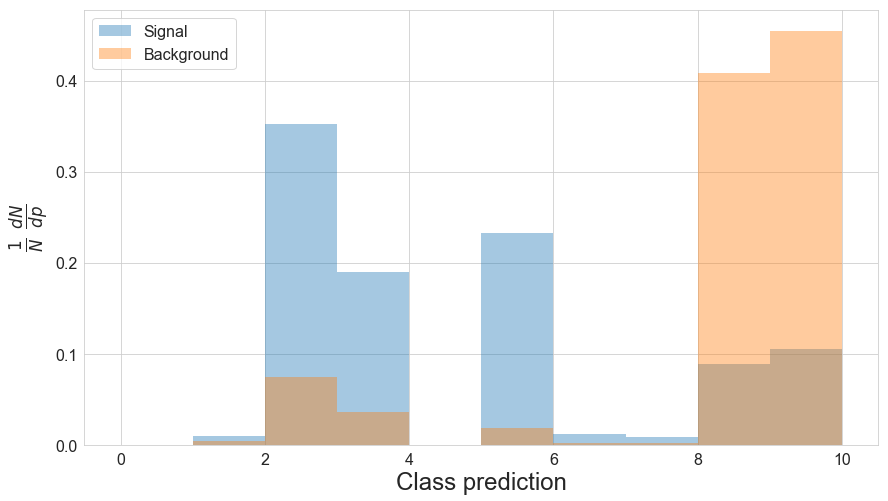

In [21]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [22]:
bin_preds(df)

In [23]:
df.head()

,pred,gen_target,pred_bin
0,5,1.0,5
1,5,1.0,5
2,5,1.0,5
3,5,1.0,5
4,2,1.0,2


In [24]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [25]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [26]:
f_s, f_b

(tensor([2.0000e-13, 9.7140e-03, 3.5272e-01, 1.8961e-01, 2.0000e-13, 2.3315e-01,
         1.1796e-02, 8.4180e-03, 8.9132e-02, 1.0546e-01]),
 tensor([2.0000e-13, 3.9600e-03, 7.4018e-02, 3.6440e-02, 2.0000e-13, 1.8162e-02,
         1.8480e-03, 2.4120e-03, 4.0828e-01, 4.5488e-01]))

In [27]:
asimov = (50*f_s)+(1000*f_b)

In [28]:
asimov, asimov.sum()

(tensor([2.1000e-10, 4.4457e+00, 9.1654e+01, 4.5921e+01, 2.1000e-10, 2.9820e+01,
         2.4378e+00, 2.8329e+00, 4.1273e+02, 4.6016e+02]), tensor(1050.))

In [29]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([23.19205666, 23.04602051, 22.90592384, 22.77137947, 22.64275551,
       22.52040291, 22.40329552, 22.29145241, 22.18527794, 22.08452034,
       21.98923874, 21.8989315 , 21.81369019, 21.73383904, 21.65895271,
       21.58906555, 21.52424622, 21.46421623, 21.40899849, 21.3584671 ,
       21.31250763, 21.27119064, 21.23436928, 21.2024765 , 21.17455673,
       21.15123177, 21.13220596, 21.11762428, 21.10710907, 21.10119438,
       21.09912872, 21.10094261, 21.10723686, 21.11694527, 21.13095856,
       21.1495285 , 21.17100525, 21.19674683, 21.22646141, 21.2597065 ,
       21.29707527, 21.33791351, 21.38202858, 21.43024063, 21.48173141,
       21.53699875, 21.59546471, 21.65757751, 21.72336578, 21.79219818,
       21.86445427, 21.94040871, 22.01919174, 22.10160637, 22.1870327 ,
       22.27564621, 22.36761665, 22.46245766, 22.56007385, 22.66129684,
       22.76571274])

In [30]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [31]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

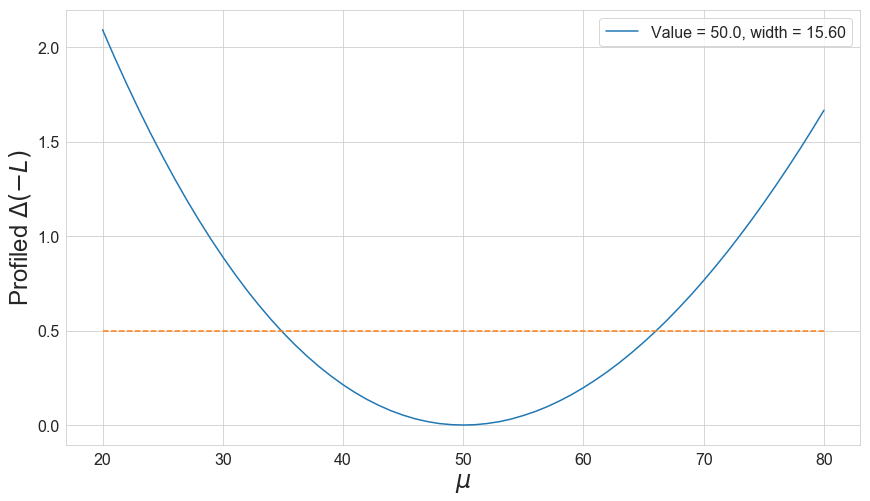

In [32]:
plot_likelihood(y-y.min())

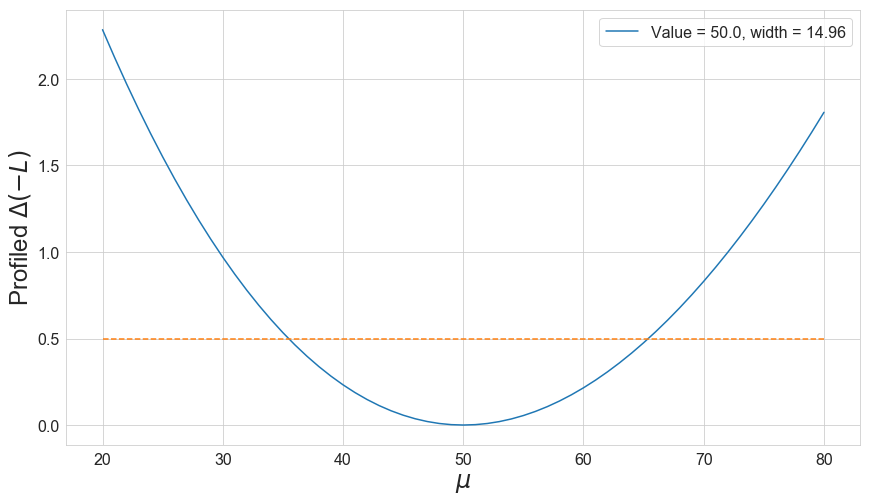

In [33]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [34]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [35]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [36]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,5,1.0,5,5,5,5,5,5,5,5,5,5,5
1,5,1.0,5,5,5,5,5,5,5,5,5,5,5
2,5,1.0,5,5,5,5,5,5,5,5,5,5,5
3,5,1.0,5,5,5,5,5,5,5,5,5,5,5
4,2,1.0,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,9,0.0,9,9,9,9,9,9,9,9,9,9,9
999996,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999997,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999998,8,0.0,8,8,8,8,8,8,8,8,8,8,8


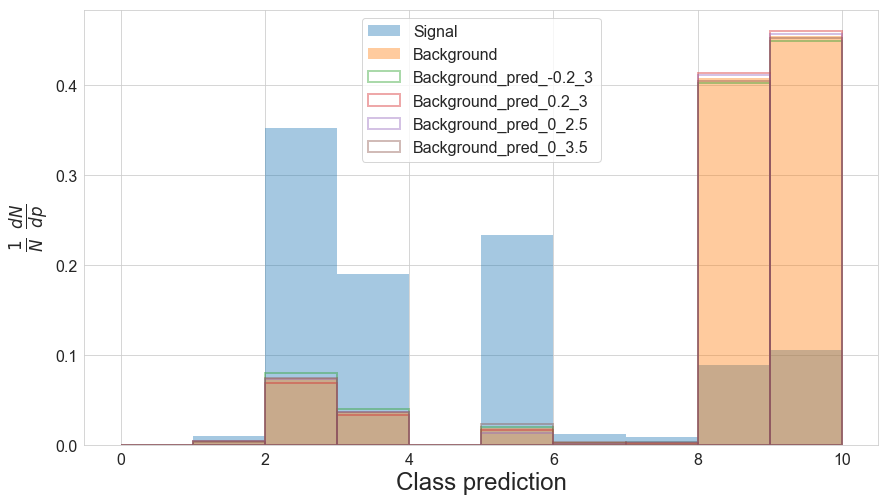

In [37]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([2.0000e-13, 4.8700e-03, 7.8932e-02, 4.0134e-02, 2.0000e-13, 1.5064e-02,
        1.0620e-03, 2.9460e-03, 4.0568e-01, 4.5131e-01])
tensor([2.0000e-13, 4.2780e-03, 7.9754e-02, 4.0140e-02, 2.0000e-13, 1.9768e-02,
        1.8460e-03, 2.6440e-03, 4.0261e-01, 4.4896e-01])
tensor([2.0000e-13, 3.7960e-03, 8.0138e-02, 4.0276e-02, 2.0000e-13, 2.4570e-02,
        2.8800e-03, 2.4040e-03, 3.9949e-01, 4.4645e-01])
tensor([2.0000e-13, 4.5520e-03, 7.3196e-02, 3.6434e-02, 2.0000e-13, 1.3458e-02,
        1.0640e-03, 2.7140e-03, 4.1135e-01, 4.5724e-01])
tensor([2.0000e-13, 3.9600e-03, 7.4018e-02, 3.6440e-02, 2.0000e-13, 1.8162e-02,
        1.8480e-03, 2.4120e-03, 4.0828e-01, 4.5488e-01])
tensor([2.0000e-13, 3.4780e-03, 7.4402e-02, 3.6576e-02, 2.0000e-13, 2.2964e-02,
        2.8820e-03, 2.1720e-03, 4.0515e-01, 4.5237e-01])
tensor([2.0000e-13, 4.3580e-03, 6.7552e-02, 3.2982e-02, 2.0000e-13, 1.1736e-02,
        1.0720e-03, 2.4500e-03, 4.1688e-01, 4.6297e-01])
tensor([2.0000e-13, 3.7660e-03, 6.8374e-0

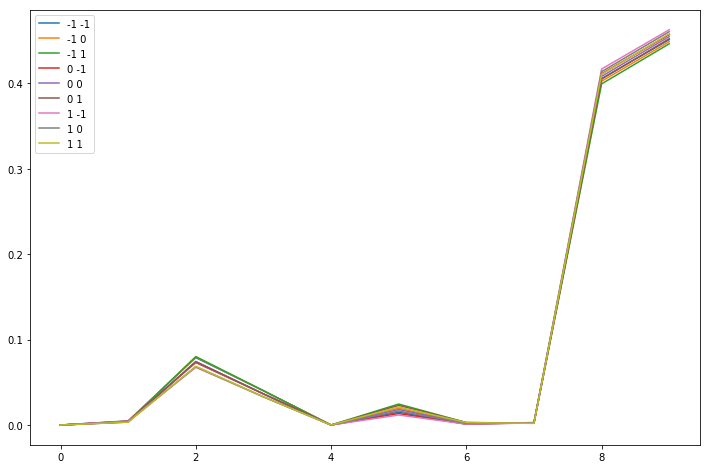

In [38]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [39]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [40]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [41]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [42]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

Linear regime: Mu 20.0, alpha tensor([-1.5926])
Linear regime: Mu 21.0, alpha tensor([-1.5382])
Linear regime: Mu 22.0, alpha tensor([-1.4838])
Linear regime: Mu 23.0, alpha tensor([-1.4296])
Linear regime: Mu 24.0, alpha tensor([-1.3754])
Linear regime: Mu 25.0, alpha tensor([-1.3214])
Linear regime: Mu 26.0, alpha tensor([-1.2675])
Linear regime: Mu 27.0, alpha tensor([-1.2136])
Linear regime: Mu 28.0, alpha tensor([-1.1599])
Linear regime: Mu 29.0, alpha tensor([-1.1062])
Linear regime: Mu 30.0, alpha tensor([-1.0527])
Linear regime: Mu 69.0, alpha tensor([1.0207])
Linear regime: Mu 70.0, alpha tensor([1.0738])
Linear regime: Mu 71.0, alpha tensor([1.1269])
Linear regime: Mu 72.0, alpha tensor([1.1799])
Linear regime: Mu 73.0, alpha tensor([1.2329])
Linear regime: Mu 74.0, alpha tensor([1.2858])
Linear regime: Mu 75.0, alpha tensor([1.3386])
Linear regime: Mu 76.0, alpha tensor([1.3914])
Linear regime: Mu 77.0, alpha tensor([1.4442])
Linear regime: Mu 78.0, alpha tensor([1.4969])
Li

In [43]:
nll = to_np(nll)

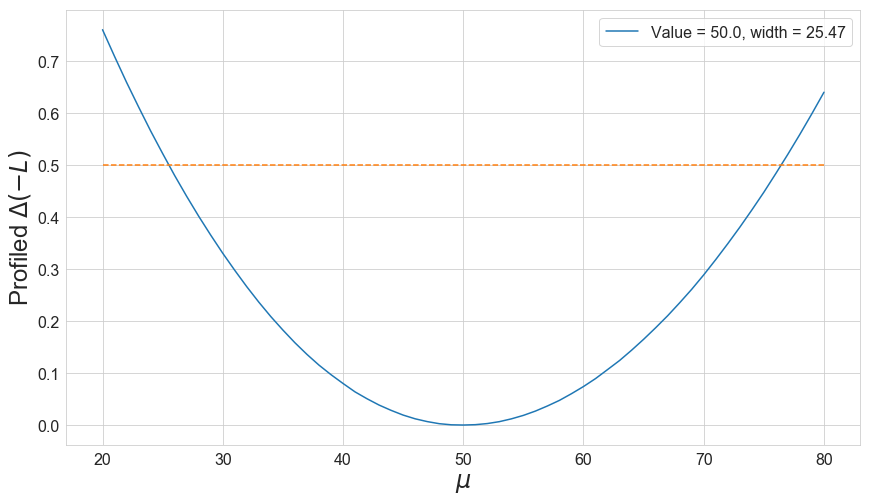

In [44]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [45]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [46]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 79.0, alpha tensor([-1.0009])
Linear regime: Mu 80.0, alpha tensor([-1.0262])


In [47]:
nll = to_np(nll)

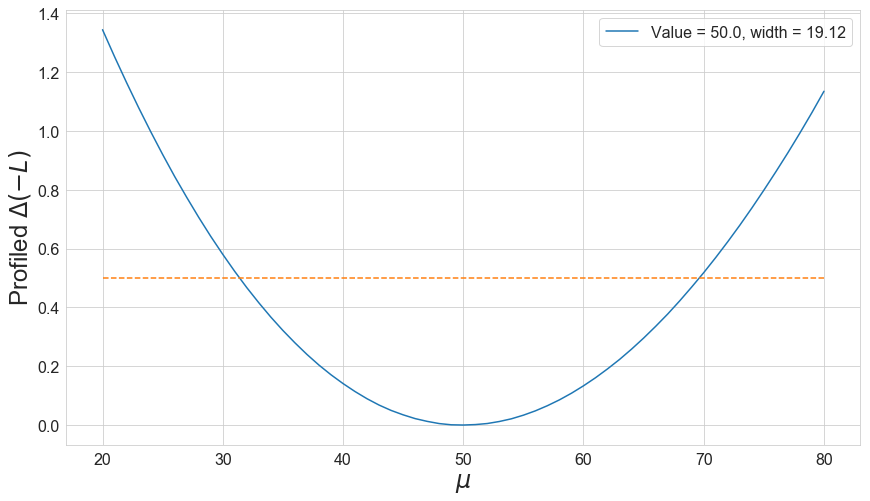

In [48]:
plot_likelihood(nll-nll.min())

## BM 2

In [49]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-1.3418,  0.6480])
Linear regime: Mu 21.0, alpha tensor([-1.2968,  0.6267])
Linear regime: Mu 22.0, alpha tensor([-1.2520,  0.6055])
Linear regime: Mu 23.0, alpha tensor([-1.2071,  0.5842])
Linear regime: Mu 24.0, alpha tensor([-1.1622,  0.5629])
Linear regime: Mu 25.0, alpha tensor([-1.1173,  0.5416])
Linear regime: Mu 26.0, alpha tensor([-1.0725,  0.5202])
Linear regime: Mu 27.0, alpha tensor([-1.0277,  0.4989])
Linear regime: Mu 72.0, alpha tensor([ 1.0180, -0.4627])
Linear regime: Mu 73.0, alpha tensor([ 1.0641, -0.4842])
Linear regime: Mu 74.0, alpha tensor([ 1.1101, -0.5058])
Linear regime: Mu 75.0, alpha tensor([ 1.1561, -0.5274])
Linear regime: Mu 76.0, alpha tensor([ 1.2021, -0.5490])
Linear regime: Mu 77.0, alpha tensor([ 1.2480, -0.5708])
Linear regime: Mu 78.0, alpha tensor([ 1.2940, -0.5925])
Linear regime: Mu 79.0, alpha tensor([ 1.3399, -0.6143])
Linear regime: Mu 80.0, alpha tensor([ 1.3858, -0.6362])


In [50]:
nll = to_np(nll)

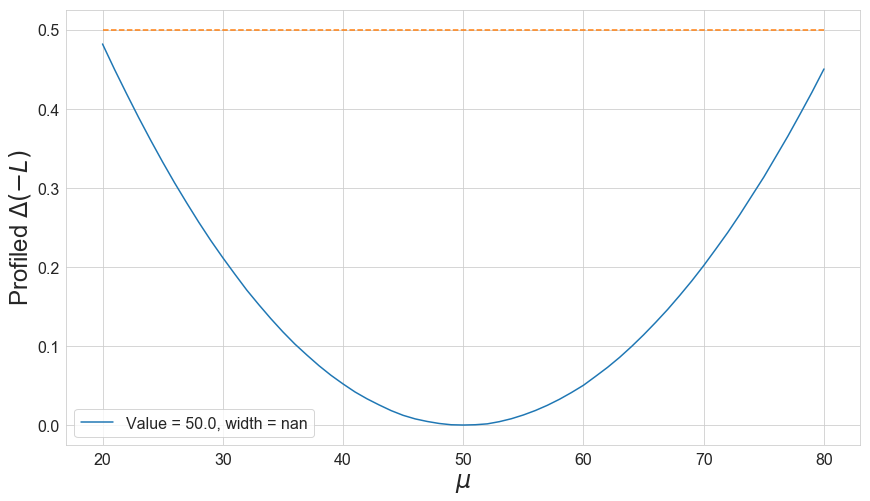

In [51]:
plot_likelihood(nll-nll.min())